# Tuning of Hyperparameters in Simple Self-EFficacy Learner Model

This notebook includes code from iterating on the Self-Efficacy Learner Behavior Model including hyperparameters for generating the set of learners in the population.

In [1]:
import sys
sys.path.append("../")

In [2]:
import logging
import random
import uuid
import os
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tutor.domain import Domain
from tutor.cogtutor_curriculum import CogTutorCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest
from learner.selfeff_learner import SelfEfficacyLearner


from simulate.self_eff_simulation import SelfEffSimulation
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper


In [4]:
#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("main")

In [5]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [6]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.debug("Base directory for the project:\n%s" % base_dir)

In [7]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:main:Writing simulation results to directory: /Users/stevenda/Sandbox/MotivSim/test/data/sim-17e45af3-6c71-4fdc-8b2d-a0caa921b69c
INFO:main:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [8]:
logger.info("Clearing database before starting new simulation")
db_util.clear_db()

INFO:main:Clearing database before starting new simulation


## Generating Learners

### Setting up Simulation

In [9]:
# Generating empty domain
domain = Domain()
domain_params = {
    'm_l0': 0.45,
    'sd_l0': 0.155,
    'm_t': 0.35,
    'sd_t': 0.13,#0.03,
    'm_s': 0.155,
    'sd_s': 0.055,
    'm_g': 0.45,#0.6,
    'sd_g': 0.105 
}
domain.set_kc_hyperparams(**domain_params)

In [10]:
# Generating the Curriculum and domain together

curric = CogTutorCurriculum(domain)
curric.generate(num_units=30,
               mean_sections=4,
               stdev_sections=2,
               mean_unit_kcs=22,
               stdev_unit_kcs=23,
               section_kcs_lambda=6,
               mean_steps=10,
               stdev_steps=4,
               mean_prob_kcs=6,
               stdev_prob_kcs=3,
               num_practice=400)


INFO:tutor.cogtutor_curriculum:Generated 30 units with with a total of 856 kcs


In [11]:
# Insert domain to db
db.domains.insert_one(domain.to_dict())
db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])

# Insert Curriculum to db
curric_util = DB_Curriculum_Mapper(db_params)
curric_util.write_to_db(curric)

INFO:log_db.curriculum_mapper:Writing curriculum with id, 7a482e30-bbbe-4d33-a484-b0ca8a6aa196, to db
INFO:log_db.curriculum_mapper:Writing 92100 problem to db
INFO:log_db.curriculum_mapper:Writing 373026 steps to db


### Initializing Learners

In [12]:
num_students = 30
students = [SelfEfficacyLearner(domain) for i in range(num_students)]
logger.info("Sample student:\n%s" % str(students[0]))
logger.info("Inserting %i students to db" % len(students))
result = db.students.insert_many([stu.to_dict() for stu in students])
logger.info("Db insert success: %s" % result.acknowledged)

INFO:main:Sample student:
INFO:main:Inserting 30 students to db
INFO:main:Db insert success: True


### Simulating Learners

In [13]:
for i, stu in enumerate(students):
    logger.info("Simulating student #%i" % i)
    sim = SelfEffSimulation(domain, curric, stu)
    sim.run()

INFO:main:Simulating student #0
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #1
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #2
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active session
INFO:main:Simulating student #3
INFO:simulate.simulation:Starting simulation. Logging student into new session
INFO:tutor.tutor:Completed last unit. No more units in curriculum
INFO:simulate.simulation:Ending simulation. Logging out of active sess

In [14]:
logger.info("Inserting %i simulated students to db" % len(students))
db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
logger.info("Db insert success: %s" % result.acknowledged)

INFO:main:Inserting 30 simulated students to db
INFO:main:Db insert success: True


In [15]:
#db_util.dump_db()

## EDA of simulated Data

In [16]:
# List size of all collections
db_util.peak()

INFO:log_db.mongo:collection name, finalsimstudents, has 30 documents
INFO:log_db.mongo:collection name, curriculum, has 0 documents
INFO:log_db.mongo:collection name, sections, has 128 documents
INFO:log_db.mongo:collection name, problems, has 92100 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, units, has 30 documents
INFO:log_db.mongo:collection name, decisions, has 568982 documents
INFO:log_db.mongo:collection name, actions, has 568982 documents
INFO:log_db.mongo:collection name, students, has 30 documents
INFO:log_db.mongo:collection name, tutor_events, has 477392 documents
INFO:log_db.mongo:collection name, steps, has 373026 documents
INFO:log_db.mongo:collection name, kcs, has 856 documents
INFO:log_db.mongo:collection name, domains, has 1 documents


In [17]:
# look at number of students in tutor_events
#tx = pd.DataFrame([evt for evt in db['tutor_events'].find({'type': "Tutor Input"})])
#logger.info(tx.shape)
#logger.info(tx.groupby('stu_id')['_id'].count())

### Domain & Cirriculum EDA

In [18]:
'''
For recovering curriculum from db if running this script 
without newly generated curriculum

''' 


#result = db.curriculums.find()
#curriculums = [c for c in result]
#print(len(curriculums))
#cid = curriculums[0]['_id']
#curric_d = curriculums[0]
#print("curriculum id: %s" % cid)

'\nFor recovering curriculum from db if running this script \nwithout newly generated curriculum\n\n'

In [19]:
#curric_util = DB_Curriculum_Mapper(db_params)
#curric = curric_util.get_from_db(cid)
#print(str(curric))

In [20]:
kc_counts = []
prob_counts = []
for j, unit in enumerate(curric.units):
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
    logger.info("Unit #%i" % j)
    for i, section in enumerate(unit.sections):
        logger.info("##########################################")
        logger.info("Section #%i: %s" % (i, section._id))
        logger.info("Number of kcs: %i" % len(section.kcs))
        kc_counts.append(len(section.kcs))
        logger.info("Number of Problems: %i" % len(section.problems))
        prob_counts.append(len(section.problems))
        step_counts = [len(prob.steps) for prob in section.problems]
        
        step_dist = {val: step_counts.count(val) for val in set(step_counts)}
        logger.info("Distribution of steps across problems: %s" % str(step_dist))
    
kc_dist = {val: kc_counts.count(val) for val in set(kc_counts)}
prob_dist = {val: prob_counts.count(val) for val in set(prob_counts)}
logger.info("------------------- Total Curric stats --------------------------")
logger.info("Distribution of kcs per section: %s" % str(kc_dist))
logger.info("Distribution of prob per section: %s" % str(prob_dist))

INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #0
INFO:main:##########################################
INFO:main:Section #0: ab49e753-92de-47d6-9021-11ec05526d40
INFO:main:Number of kcs: 2
INFO:main:Number of Problems: 211
INFO:main:Distribution of steps across problems: {1: 25, 2: 31, 3: 37, 4: 43, 5: 28, 6: 29, 7: 11, 8: 7}
INFO:main:##########################################
INFO:main:Section #1: 4b281180-165b-4239-883a-3f186d6ca66d
INFO:main:Number of kcs: 3
INFO:main:Number of Problems: 274
INFO:main:Distribution of steps across problems: {1: 23, 2: 27, 3: 37, 4: 59, 5: 44, 6: 43, 7: 26, 8: 8, 9: 6, 11: 1}
INFO:main:##########################################
INFO:main:Section #2: 9f2fc231-112b-4d45-a817-f841993e3a17
INFO:main:Number of kcs: 4
INFO:main:Number of Problems: 422
INFO:main:Distribution of steps across problems: {1: 51, 2: 39, 3: 66, 4: 85, 5: 83, 6: 53, 7: 29, 8: 10, 9: 5, 10: 1}
INFO:main:#####

INFO:main:Distribution of steps across problems: {1: 13, 2: 13, 3: 14, 4: 24, 5: 16, 6: 13, 7: 7, 8: 2}
INFO:main:##########################################
INFO:main:Section #4: 7aed1294-cc5e-4af3-bcae-1da3762c2d7c
INFO:main:Number of kcs: 8
INFO:main:Number of Problems: 829
INFO:main:Distribution of steps across problems: {1: 97, 2: 91, 3: 154, 4: 161, 5: 139, 6: 98, 7: 58, 8: 22, 9: 9}
INFO:main:##########################################
INFO:main:Section #5: a3e5a8fa-a66b-44f7-a209-c401e50b6b16
INFO:main:Number of kcs: 6
INFO:main:Number of Problems: 613
INFO:main:Distribution of steps across problems: {1: 67, 2: 84, 3: 97, 4: 103, 5: 112, 6: 69, 7: 50, 8: 23, 9: 8}
INFO:main:##########################################
INFO:main:Section #6: ea359615-b361-45e7-8750-a9912b4f8e98
INFO:main:Number of kcs: 8
INFO:main:Number of Problems: 813
INFO:main:Distribution of steps across problems: {1: 66, 2: 92, 3: 142, 4: 176, 5: 115, 6: 132, 7: 57, 8: 19, 9: 10, 10: 4}
INFO:main:##############

INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #11
INFO:main:##########################################
INFO:main:Section #0: 4cc84cbe-d586-4d5f-88e6-71100da11ec9
INFO:main:Number of kcs: 2
INFO:main:Number of Problems: 198
INFO:main:Distribution of steps across problems: {1: 26, 2: 21, 3: 25, 4: 40, 5: 40, 6: 29, 7: 8, 8: 7, 9: 2}
INFO:main:##########################################
INFO:main:Section #1: 1c405cdc-40be-45db-bb30-60d74704392c
INFO:main:Number of kcs: 9
INFO:main:Number of Problems: 996
INFO:main:Distribution of steps across problems: {1: 95, 2: 123, 3: 178, 4: 198, 5: 191, 6: 115, 7: 51, 8: 26, 9: 16, 10: 2, 11: 1}
INFO:main:##########################################
INFO:main:Section #2: 917fc7f7-486e-4d0b-bb8c-5d6bb1f7f326
INFO:main:Number of kcs: 3
INFO:main:Number of Problems: 308
INFO:main:Distribution of steps across problems: {1: 40, 2: 35, 3: 50, 4: 62, 5: 45, 6: 36, 7: 26, 8: 9, 9: 4, 10:

INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #18
INFO:main:##########################################
INFO:main:Section #0: d6c8ce2b-23c1-410e-9dcc-0c21b6fa8984
INFO:main:Number of kcs: 3
INFO:main:Number of Problems: 315
INFO:main:Distribution of steps across problems: {1: 44, 2: 33, 3: 57, 4: 71, 5: 49, 6: 31, 7: 18, 8: 11, 9: 1}
INFO:main:##########################################
INFO:main:Section #1: fa44e937-05bd-4a5e-8525-562ae81992fa
INFO:main:Number of kcs: 1
INFO:main:Number of Problems: 99
INFO:main:Distribution of steps across problems: {1: 11, 2: 7, 3: 17, 4: 27, 5: 20, 6: 7, 7: 6, 8: 3, 9: 1}
INFO:main:##########################################
INFO:main:Section #2: 8bf49f48-e648-4438-a00f-ee6ea1b9fad4
INFO:main:Number of kcs: 6
INFO:main:Number of Problems: 644
INFO:main:Distribution of steps across problems: {1: 79, 2: 66, 3: 111, 4: 139, 5: 119, 6: 70, 7: 41, 8: 10, 9: 5, 10: 4}
INFO:main:##########################################
INFO:main:Secti

INFO:main:Number of Problems: 946
INFO:main:Distribution of steps across problems: {1: 107, 2: 106, 3: 157, 4: 184, 5: 185, 6: 98, 7: 67, 8: 25, 9: 11, 10: 5, 12: 1}
INFO:main:##########################################
INFO:main:Section #1: b995e0df-433d-4ccb-a840-cd8898c9da3d
INFO:main:Number of kcs: 3
INFO:main:Number of Problems: 305
INFO:main:Distribution of steps across problems: {1: 26, 2: 36, 3: 55, 4: 70, 5: 62, 6: 25, 7: 21, 8: 7, 9: 3}
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
INFO:main:Unit #24
INFO:main:##########################################
INFO:main:Section #0: 23d592e0-6b7d-4942-b198-5289800a6ab2
INFO:main:Number of kcs: 5
INFO:main:Number of Problems: 501
INFO:main:Distribution of steps across problems: {1: 44, 2: 55, 3: 99, 4: 100, 5: 79, 6: 57, 7: 43, 8: 17, 9: 5, 10: 2}
INFO:main:##########################################
INFO:main:Section #1: 1277a718-0713-445f-ad1b-0afdccc636a6
INFO:main:Number of 

INFO:main:------------------- Total Curric stats --------------------------
INFO:main:Distribution of kcs per section: {1: 26, 2: 15, 3: 11, 4: 7, 5: 14, 6: 7, 7: 4, 8: 7, 9: 9, 10: 2, 11: 3, 12: 3, 13: 3, 14: 1, 15: 2, 16: 5, 17: 1, 18: 1, 21: 1, 22: 2, 23: 1, 27: 2, 33: 1}
INFO:main:Distribution of prob per section: {514: 2, 515: 1, 524: 1, 529: 1, 1555: 1, 533: 1, 543: 2, 549: 1, 1067: 1, 1598: 1, 1106: 1, 2644: 1, 92: 2, 93: 1, 94: 1, 95: 2, 96: 2, 97: 1, 98: 2, 99: 1, 100: 3, 613: 1, 102: 2, 101: 3, 104: 1, 105: 1, 103: 3, 109: 1, 1658: 1, 636: 1, 640: 1, 641: 1, 644: 2, 1161: 1, 1178: 1, 1694: 1, 186: 1, 3775: 1, 198: 2, 200: 1, 201: 1, 203: 1, 204: 2, 207: 1, 209: 1, 210: 2, 211: 2, 724: 1, 212: 1, 736: 1, 1765: 1, 1767: 1, 1256: 1, 750: 1, 1779: 1, 756: 1, 1271: 1, 1786: 1, 1791: 1, 1280: 1, 1284: 1, 274: 1, 2345: 1, 813: 1, 304: 1, 305: 2, 307: 1, 308: 1, 312: 1, 313: 1, 315: 2, 829: 1, 830: 1, 318: 1, 832: 1, 835: 1, 2896: 1, 2386: 1, 1884: 1, 870: 1, 1382: 1, 874: 1, 395: 1,

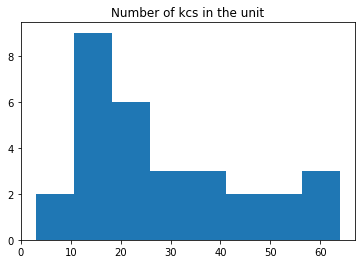

INFO:main:Total number of kcs: 856
INFO:main:count    30.000000
mean     28.533333
std      17.254152
min       3.000000
25%      14.500000
50%      24.000000
75%      36.500000
max      64.000000
dtype: float64


In [21]:
# Unit EDA
unit_kcs = [len(unit.kcs) for unit in curric.units]
plt.hist(unit_kcs, bins=8)
plt.title("Number of kcs in the unit")
plt.show()
logger.info("Total number of kcs: %i" % np.sum(unit_kcs))
logger.info(pd.Series(unit_kcs).describe())

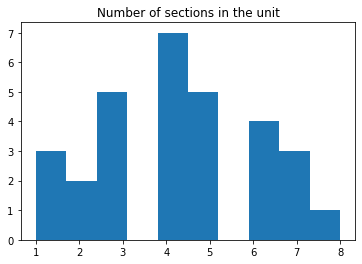

INFO:main:Total number of sections: 128
INFO:main:count    30.000000
mean      4.266667
std       1.874205
min       1.000000
25%       3.000000
50%       4.000000
75%       5.750000
max       8.000000
dtype: float64


In [22]:
#Section EDA
unit_sections = [len(unit.sections) for unit in curric.units]
plt.hist(unit_sections, bins=10)
plt.title("Number of sections in the unit")
plt.show()
logger.info("Total number of sections: %i" % np.sum(unit_sections))
logger.info(pd.Series(unit_sections).describe())

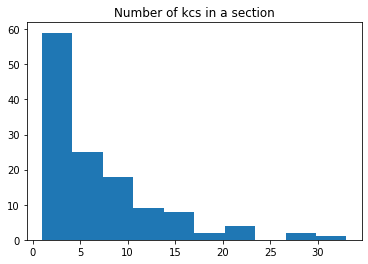

INFO:main:count    128.000000
mean       6.687500
std        6.320508
min        1.000000
25%        2.000000
50%        5.000000
75%        9.000000
max       33.000000
dtype: float64


In [23]:
section_kcs = []
for unit in curric.units:
    section_kcs.extend([len(section.kcs) for section in unit.sections])
plt.hist(section_kcs, bins=10)
plt.title("Number of kcs in a section")
plt.show()
logger.info(pd.Series(section_kcs).describe())

INFO:main:Distribution of steps per problems: 
1      9833.0
2     11112.0
3     16059.0
4     18242.0
5     16161.0
6     10921.0
7      6130.0
8      2527.0
9       848.0
10      207.0
11       55.0
12        5.0
dtype: float64


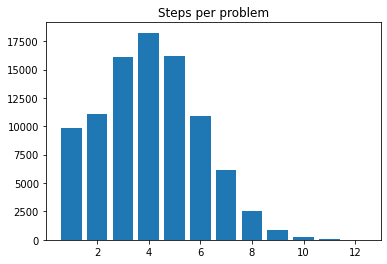

In [24]:
# steps per problem EDA
step_counts = []
for unit in curric.units:
    for section in unit.sections:
 #       logger.info("Section with %i kcs and %i problems" % (len(section.kcs), len(section.problems)))
        counts = pd.Series([len(prob.steps) for prob in section.problems]).value_counts()
#        logger.info("Counts of steps per problems \n%s" % str(counts))
        step_counts.append(counts)

    
prob_steps = pd.DataFrame(step_counts).sum(axis=0)
logger.info("Distribution of steps per problems: \n%s" %  str(prob_steps))
plt.bar(prob_steps.index, prob_steps)
plt.title("Steps per problem")
plt.show()

### Student EDA

In [25]:
logger.info("Getting pre-sim students")
presim_students = pd.DataFrame(db.students.find())
sim_students = pd.DataFrame(db.finalsimstudents.find())
sim_students.rename(columns={'skills': 'final skills', 
                             'total_attempts': 'final total attempts',
                             'total_success': 'final total success'}, inplace=True)

logger.info("pre-sim students: %s" % str(presim_students.shape))
logger.info("post-sim students: %s" % str(sim_students.shape))


sim_students = presim_students.merge(sim_students[['_id', 'final skills', 'final total attempts', 'final total success']], how='right', on=['_id'])
sim_students['pre-sim total mastery'] = sim_students.apply(lambda x: np.sum(list(x['skills'].values())), axis=1)
sim_students['final-sim total mastery'] = sim_students.apply(lambda x: np.sum(list(x['final skills'].values())), axis=1)
sim_students['total skills'] = sim_students.apply(lambda x: len(list(x['skills'].values())), axis=1)
sim_students['pre-sim pct mastery'] = sim_students.apply(lambda x: x['pre-sim total mastery'] / x['total skills'], axis=1)
sim_students['final-sim pct mastery'] = sim_students.apply(lambda x: x['final-sim total mastery'] / x['total skills'], axis=1)
sim_students['final-sim total unmastered'] = sim_students.apply(lambda x: x['total skills'] - x['final-sim total mastery'], axis=1)
sim_students['final self-eff'] = sim_students.apply(lambda x: ((x['self_eff'] * 100) + x['final total success']) / (500 + x['final total attempts']), axis=1)
sim_students['pct success'] = sim_students.apply(lambda x: x['final total success'] / x['final total attempts'], axis=1)
sim_students.head()

INFO:main:Getting pre-sim students
INFO:main:pre-sim students: (30, 13)
INFO:main:post-sim students: (30, 13)


,_id,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,diligence,self_eff,...,final total attempts,final total success,pre-sim total mastery,final-sim total mastery,total skills,pre-sim pct mastery,final-sim pct mastery,final-sim total unmastered,final self-eff,pct success
0,2311692b-3770-4407-a455-d49e35719486,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,{'f724a837-2aa8-4797-b801-67ceb2e43a82': False...,30,1200,3,1,2.060367,0.419716,...,15347,10375,393,852,856,0.459112,0.995327,4,0.657347,0.676028
1,54f8e8f9-b792-4473-89bb-e15991989572,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,{'f724a837-2aa8-4797-b801-67ceb2e43a82': False...,30,1200,3,1,2.304944,0.611095,...,13098,8890,364,849,856,0.425234,0.991822,7,0.658267,0.678730
2,81d87a8c-367c-432c-8d71-b0d7fe4bac0d,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,{'f724a837-2aa8-4797-b801-67ceb2e43a82': False...,30,1200,3,1,1.382105,0.322094,...,14782,9637,416,852,856,0.485981,0.995327,4,0.632719,0.651942
3,7d1a77c9-4c9e-439e-855f-a8da9ae10dd5,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,"{'f724a837-2aa8-4797-b801-67ceb2e43a82': True,...",30,1200,3,1,2.162972,0.313305,...,13433,9134,413,855,856,0.482477,0.998832,1,0.657815,0.679967
4,e1b14123-0c63-45e5-aef6-04dc8321dfec,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,{'f724a837-2aa8-4797-b801-67ceb2e43a82': False...,30,1200,3,1,2.278465,0.623705,...,14876,9469,385,843,856,0.449766,0.984813,13,0.619886,0.636529


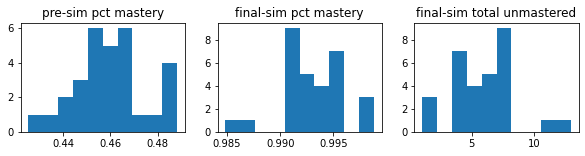

INFO:main:Total skills: 856


In [26]:
# Plot mastery
plt.figure(figsize=(10,2))
plt.subplot(131)
plt.hist(sim_students['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(132)
plt.hist(sim_students['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")

plt.subplot(133)
plt.hist(sim_students['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()
logger.info("Total skills: %i" % sim_students['total skills'][0])

0: attempt
1: guess
2: hint request
3: off task


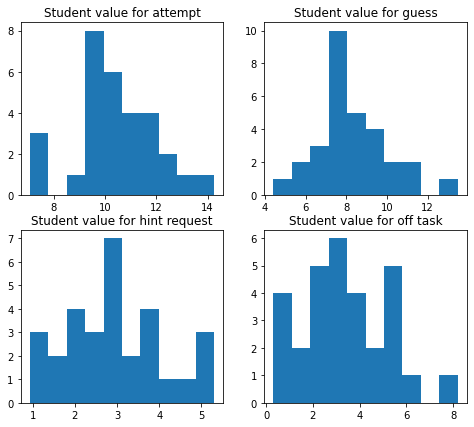

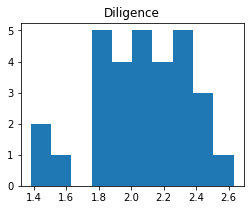

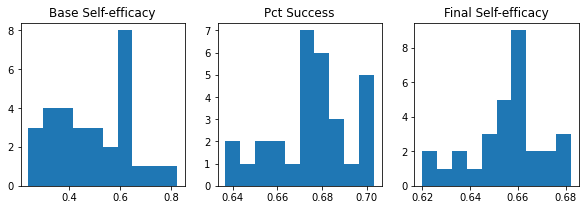

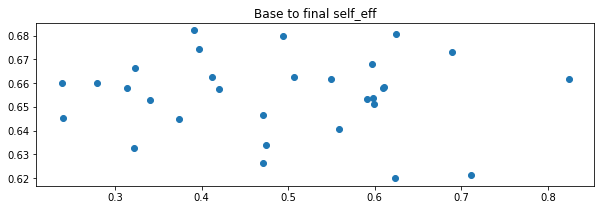

In [27]:
# Plot Values & Diligence
plt.figure(figsize=(8,7))
for i,val in enumerate(sim_students['values'][0].keys()):
    print("%i: %s" % (i, val))
    plt.subplot(2,2,i+1)
    plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
    plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(4,3))
plt.hist(sim_students['diligence'], bins=10)
plt.title("Diligence")
plt.show()

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.hist(sim_students['self_eff'], bins=10)
plt.title("Base Self-efficacy")
plt.subplot(1,3,2)
plt.hist(sim_students['pct success'], bins=10)
plt.title("Pct Success")
plt.subplot(1,3,3)
plt.hist(sim_students['final self-eff'], bins=10)
plt.title("Final Self-efficacy")
plt.show()

plt.figure(figsize=(10,3))
plt.scatter(sim_students['self_eff'], sim_students['final self-eff'])
plt.title("Base to final self_eff")
plt.show()



### Learner Actions EDA

In [28]:
# Get Learner actions
actions = pd.DataFrame(db.actions.find())
actions['type'] = actions.apply(lambda x: x['action']['name'], axis=1)
actions['duration'] = actions.apply(lambda x: x['action']['time'], axis=1)
actions.head()

,_id,student_id,action,time,type,duration
0,f005cf51-3ec8-4cc9-a971-c7f1a542cbe2,2311692b-3770-4407-a455-d49e35719486,"{'name': 'Attempt', 'time': 2.2046847505617397...",2020-10-21 14:59:49.982,Attempt,2.204685
1,1204db9d-6533-4da4-a749-113c97db0f58,2311692b-3770-4407-a455-d49e35719486,"{'name': 'Attempt', 'time': 20.732461851691475...",2020-10-21 14:59:52.187,Attempt,20.732462
2,f90c06b0-7f50-40d3-9a5c-4bc1c2a855fd,2311692b-3770-4407-a455-d49e35719486,"{'name': 'Hint Request', 'time': 3.16367833781...",2020-10-21 15:00:12.919,Hint Request,3.163678
3,807813a0-17f6-4ed0-bad6-db8b87c1bf36,2311692b-3770-4407-a455-d49e35719486,"{'name': 'Hint Request', 'time': 3.55814547474...",2020-10-21 15:00:16.083,Hint Request,3.558145
4,7517167c-dce4-445f-80f9-87fff2168aee,2311692b-3770-4407-a455-d49e35719486,"{'name': 'Attempt', 'time': 3.5442413070882974...",2020-10-21 15:00:19.641,Attempt,3.544241


In [29]:
action_dist = actions.groupby('student_id')['type'].value_counts().reset_index(name="count")
action_dist = action_dist.pivot(index='student_id', columns='type', values='count')
action_dist['total'] = action_dist.sum(axis=1)
for col in action_dist.columns:
    if col != 'total':
        action_dist['Pct %s' % col] = action_dist.apply(lambda x: x[col]/x['total'], axis=1)
action_dist.head()

type,Attempt,Guess,Hint Request,Off Task,total,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task
student_id,,,,,,,,,
05ed47bd-67b0-469c-a574-994c9a08c3bb,14316,1387,2029,5304,23036,0.621462,0.060210,0.088080,0.230248
08fadae4-392d-43f8-82c5-cdd0fba45be4,11529,687,2006,1609,15831,0.728255,0.043396,0.126713,0.101636
18388598-37fd-41ee-b0dc-ed6e3e1c282c,10714,940,983,4273,16910,0.633590,0.055588,0.058131,0.252691
1a735c62-85c2-45bb-ae86-85cc11cdec19,11739,680,2317,2548,17284,0.679183,0.039343,0.134055,0.147420
2311692b-3770-4407-a455-d49e35719486,14175,1172,4095,5299,24741,0.572936,0.047371,0.165515,0.214179


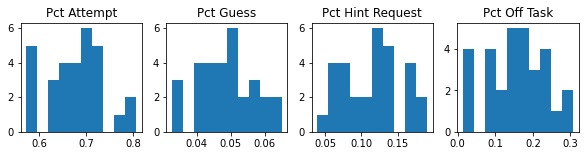

In [30]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(action_dist['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(action_dist['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(action_dist['Pct Hint Request'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(action_dist['Pct Off Task'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Decisions EDA

In [31]:
# Get Learner actions
decisions = pd.DataFrame(db.decisions.find())
decisions['learner_knowledge'] = decisions['learner_knowledge'].apply(lambda x: x[0] if isinstance(x, Iterable) else x)
decisions['kcid'] = decisions['kc'].apply(lambda x: x['_id'])
decisions.head()

,_id,student_id,choice,time,action_evs,pev,problem,step,kc,learner_knowledge,attempt,hints_avail,hints_used,learner_off_task,self_eff,kcid
0,d63e8f18-be21-43cf-8f57-aa8499ee1f3f,2311692b-3770-4407-a455-d49e35719486,Attempt,2020-10-21 14:59:49.982,"{'Attempt': 8.02994765475348, 'Guess': 1.06968...","[0.32321324689780745, 0.04305596709306822, 0.4...",3ddb4ba3-c126-4028-bf2f-a0a862fd6750,742b285c-752c-4e60-9166-f457e268286e,{'_id': '517227f9-9920-4312-8511-f260d76bf45c'...,False,0,3,0,False,0.419716,517227f9-9920-4312-8511-f260d76bf45c
1,43dc7fc7-3b79-4199-8dae-157f875aadc9,2311692b-3770-4407-a455-d49e35719486,Attempt,2020-10-21 14:59:52.187,"{'Attempt': 8.041038483193836, 'Guess': 2.1732...","[0.30976143736725503, 0.08372072534455353, 0.4...",3ddb4ba3-c126-4028-bf2f-a0a862fd6750,483be9fc-5a1d-48bb-bfe5-4e9255001e24,{'_id': 'f724a837-2aa8-4797-b801-67ceb2e43a82'...,False,0,3,0,False,0.420296,f724a837-2aa8-4797-b801-67ceb2e43a82
2,3d48b9b6-17cd-4bcc-907b-92a8130eb7b0,2311692b-3770-4407-a455-d49e35719486,HintRequest,2020-10-21 15:00:12.919,"{'Attempt': 8.052107174252075, 'Guess': 1.8086...","[0.31447122032607694, 0.0706355281732986, 0.42...",eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,{'_id': '517227f9-9920-4312-8511-f260d76bf45c'...,False,0,3,0,False,0.420874,517227f9-9920-4312-8511-f260d76bf45c
3,ccc4eb14-9f16-40a5-911e-7d6508fe76bf,2311692b-3770-4407-a455-d49e35719486,HintRequest,2020-10-21 15:00:16.083,"{'Attempt': 11.745360424017901, 'Guess': 1.925...","[0.399296735499446, 0.06545190540979111, 0.366...",eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,{'_id': '517227f9-9920-4312-8511-f260d76bf45c'...,False,1,2,1,False,0.420874,517227f9-9920-4312-8511-f260d76bf45c
4,576fe93c-c68f-40fb-944c-b0fb744ca54f,2311692b-3770-4407-a455-d49e35719486,Attempt,2020-10-21 15:00:19.641,"{'Attempt': 15.43861367378373, 'Guess': 1.6881...","[0.46966957852208946, 0.051355804797706545, 0....",eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,{'_id': '517227f9-9920-4312-8511-f260d76bf45c'...,False,2,1,2,False,0.420874,517227f9-9920-4312-8511-f260d76bf45c


In [32]:
decisions[['problem', 'step', 'kcid', 'learner_knowledge', 'choice']].head(20)

,problem,step,kcid,learner_knowledge,choice
0,3ddb4ba3-c126-4028-bf2f-a0a862fd6750,742b285c-752c-4e60-9166-f457e268286e,517227f9-9920-4312-8511-f260d76bf45c,False,Attempt
1,3ddb4ba3-c126-4028-bf2f-a0a862fd6750,483be9fc-5a1d-48bb-bfe5-4e9255001e24,f724a837-2aa8-4797-b801-67ceb2e43a82,False,Attempt
2,eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,517227f9-9920-4312-8511-f260d76bf45c,False,HintRequest
3,eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,517227f9-9920-4312-8511-f260d76bf45c,False,HintRequest
4,eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,517227f9-9920-4312-8511-f260d76bf45c,False,Attempt
5,eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,517227f9-9920-4312-8511-f260d76bf45c,False,Attempt
6,eecaf799-d63f-4793-b763-5cf226b8d4c1,d717c5b0-a9bf-4ff0-b58f-fe019adc9f65,517227f9-9920-4312-8511-f260d76bf45c,False,HintRequest
7,eecaf799-d63f-4793-b763-5cf226b8d4c1,d717c5b0-a9bf-4ff0-b58f-fe019adc9f65,517227f9-9920-4312-8511-f260d76bf45c,True,OffTask
8,eecaf799-d63f-4793-b763-5cf226b8d4c1,d717c5b0-a9bf-4ff0-b58f-fe019adc9f65,517227f9-9920-4312-8511-f260d76bf45c,True,Attempt
9,049e7303-9923-4a76-b021-efa5e4dd8e49,da1fafd0-cf15-40b8-85ac-7c5b8169e3c1,517227f9-9920-4312-8511-f260d76bf45c,True,OffTask


In [33]:
print(decisions['kc'][0])
print(decisions['action_evs'][0])
print(decisions['pev'][0])

{'_id': '517227f9-9920-4312-8511-f260d76bf45c', 'domain_id': 'fa479877-926f-4f3c-a0b1-8d70a4588c09', 'pl0': 0.24525280628133125, 'pt': 0.2273326469300616, 'ps': 0.1451642152744182, 'pg': 0.3906182545056978, 'm_time': 2.0981674957929295, 'sd_time': 0.5245418739482324}
{'Attempt': 8.02994765475348, 'Guess': 1.0696874750663925, 'HintRequest': 10.77540900299442, 'OffTask': 4.969072659503825}
[0.32321324689780745, 0.04305596709306822, 0.4337207513984241, 0.2000100346107002]


In [34]:
decision_kc_stats = decisions.groupby(['student_id', 'kcid'])['learner_knowledge'].agg(['count', 'sum'])
decision_kc_stats.head(50)

count  \
student_id                           kcid                                          
05ed47bd-67b0-469c-a574-994c9a08c3bb 000545ba-e37a-47c9-8db4-b82649187548     23   
                                     003a71a5-ce7d-49c8-8d3a-5458aa04cbce     10   
                                     0089ebe7-3b1e-49dd-9d7f-4e3e88a34448     12   
                                     00dd1c34-8687-4ed1-9f75-2778d4ebb792     16   
                                     00e5305c-fde0-46fd-9a75-01cce164d038     14   
                                     01191be0-782f-409a-902d-d194b908c8a8      8   
                                     018fd738-da54-4876-be3f-ff99a0f87ea3     26   
                                     01b61e98-e1a4-426c-a50b-9610c10fad5b      9   
                                     01e6d227-37c0-4052-b08f-c9f975e49983      6   
                                     01e93297-4bb0-4132-b56f-71a14a1474c1     10   
                                     0206a402-f355-4a8d-bc12-2f3272a33aa6     12   
                                     020bf61c-ca6a-4ef9-a190-224b203d29fc     12   
                                     023a422b-6b24-4b10-8572-2af5c5e56a42     26   
                                     02b53873-9914-454f-b886-d8fb471accae      9   
                                     02ba877e-1e20-45b9-b5ba-2495f07da368     11   
                                     02d5a641-1afd-41b0-aaa5-31872e0d3135      7   
                                     0340ffcc-1c6c-4803-a6ed-8f76879b4dc7     14   
                                     0363ba44-1a2c-434b-a87f-93736c281ef9     11   
                                     043d93c7-5f9a-4178-882a-3447d91fe5d3     13   
                                     046ff565-b5d8-4ab1-ae3e-1d5b814aa62a     18   
                                     04e53728-2388-49b5-976f-c6a2876c3c6d     13   
                                     051ef025-68cc-4782-9504-3f01e4d53923     58   
                                     05400be0-9d5d-4580-aa4f-69a66d7953b7      8   
                                     054a81b6-79b6-4e2c-ad0f-e6fc3125333b     22   
                                     055d43cf-90e6-4365-b8ec-ec6e705cb5a0      6   
                                     05a2fb5f-b0db-4674-b656-2f0d9ec2cc41     28   
                                     06e61272-8f97-4652-8692-031f34f39e08     53   
                                     074e92b2-85fa-4f4f-aeff-4689dfcf4212     17   
                                     076baa01-3a21-4b7b-a672-e0fd12fbb24e     10   
                                     07a05869-c47b-4e56-a749-bac46f1247fd     67   
                                     07ab5df3-3761-4be7-af80-dd9776be221b     54   
                                     07abf57a-9185-482a-9523-c6dc432329e9     30   
                                     07b173cd-d68c-4527-b5cf-108a4969a8fb     22   
                                     07c49d78-bcc2-4079-9fff-a794da9e6ae4     26   
                                     0810dccd-daaa-4170-a0f6-a05ce6740ec8     22   
                                     0813c1f9-a6b2-49be-b8e1-494378bf6417     51   
                                     08d3dea7-11b2-4c18-b615-d5a6783b40bd     18   
                                     0927a3b9-fb89-4250-aacb-715a06f807e9     38   
                                     09998e0d-e90c-4883-9847-8e6d2213f0a7     29   
                                     09a70009-3099-4dae-b559-e43a6b14d904     13   
                                     09b0eb2a-af0f-4b93-a3a8-55d7808aeba8     25   
                                     09b77ec1-93dd-460c-b933-926f3685342c     25   
                                     09bb985e-87ea-4348-928c-a8ee4fa89376      6   
                                     0acab400-5f91-4d49-8fe0-c90cd3545a00     73   
                                     0af8debd-32ab-4daf-a0d4-60c9a4425c1a     48   
                                     0b4ec5b4-ce34-4b59-83b5-79325626d9e9     21   
                                     0b65fa

#### Learner Transactions EDA

In [35]:
# Get learner transactions
tx = pd.DataFrame(db.tutor_events.find({'type': "Tutor Input"}))
logger.info("Learner Transactions: %s" % str(tx.shape))
tx.head()

INFO:main:Learner Transactions: (477332, 17)


,_id,type,time,curric_id,unit_id,section_id,prob_id,step_id,stu_id,duration,outcome,kcs,plt,plt1,hints_used,hints_avail,attempt
0,bb532e0d-7882-4594-af43-38321104b915,Tutor Input,2020-10-21 14:59:52.187,7a482e30-bbbe-4d33-a484-b0ca8a6aa196,8901ec2b-73c2-4a6d-9f0b-facce37f1731,ab49e753-92de-47d6-9021-11ec05526d40,3ddb4ba3-c126-4028-bf2f-a0a862fd6750,742b285c-752c-4e60-9166-f457e268286e,2311692b-3770-4407-a455-d49e35719486,2.204685,Correct,[{'_id': '517227f9-9920-4312-8511-f260d76bf45c...,0.245253,0.548443,0,3,0
1,f9771d2d-f768-4787-8a4c-e7c4f5a621ee,Tutor Input,2020-10-21 15:00:12.919,7a482e30-bbbe-4d33-a484-b0ca8a6aa196,8901ec2b-73c2-4a6d-9f0b-facce37f1731,ab49e753-92de-47d6-9021-11ec05526d40,3ddb4ba3-c126-4028-bf2f-a0a862fd6750,483be9fc-5a1d-48bb-bfe5-4e9255001e24,2311692b-3770-4407-a455-d49e35719486,20.732462,Correct,[{'_id': 'f724a837-2aa8-4797-b801-67ceb2e43a82...,0.295231,0.619808,0,3,0
2,46d15be6-2e1e-4689-891b-84a7521dc6cc,Tutor Input,2020-10-21 15:00:16.083,7a482e30-bbbe-4d33-a484-b0ca8a6aa196,8901ec2b-73c2-4a6d-9f0b-facce37f1731,ab49e753-92de-47d6-9021-11ec05526d40,eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,2311692b-3770-4407-a455-d49e35719486,3.163678,Hint,[{'_id': '517227f9-9920-4312-8511-f260d76bf45c...,0.548443,0.400721,0,3,0
3,f1423dfd-ff23-4e99-b6a5-2ef05b088efc,Tutor Input,2020-10-21 15:00:19.641,7a482e30-bbbe-4d33-a484-b0ca8a6aa196,8901ec2b-73c2-4a6d-9f0b-facce37f1731,ab49e753-92de-47d6-9021-11ec05526d40,eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,2311692b-3770-4407-a455-d49e35719486,3.558145,Hint,[{'_id': '517227f9-9920-4312-8511-f260d76bf45c...,0.400721,0.400721,1,2,1
4,3e58fa77-8f5c-41fc-8519-ce1340f4c4cf,Tutor Input,2020-10-21 15:00:23.185,7a482e30-bbbe-4d33-a484-b0ca8a6aa196,8901ec2b-73c2-4a6d-9f0b-facce37f1731,ab49e753-92de-47d6-9021-11ec05526d40,eecaf799-d63f-4793-b763-5cf226b8d4c1,fb2b8c8c-28c4-43a2-890e-507cda1f352c,2311692b-3770-4407-a455-d49e35719486,3.544241,Incorrect,[{'_id': '517227f9-9920-4312-8511-f260d76bf45c...,0.400721,0.400721,2,1,2


In [36]:
# Add kc field that reduces list of kcs to 1 kc
tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)

In [37]:
# Aggregate Learner transaction stats

# Total Transaction counts
stu_stats = tx.groupby('stu_id').agg({'_id': 'count', 
                                      'duration': np.sum,
                                     })
stu_stats.rename(columns={'_id': "Total Tx",
                          'duration': 'Total Time'}, 
                         inplace = True)
stu_stats['Total Time(hours)'] = stu_stats['Total Time'].apply(lambda x: x / 3600)
logger.info("Number of students: %i" % stu_stats.shape[0])
logger.info(stu_stats["Total Tx"].describe())

# Total of each outcome
d = tx.groupby(['stu_id','outcome'])['_id'].count().reset_index().pivot(index='stu_id', columns='outcome', values='_id')

# Prorporation of each outcome
stu_stats = pd.concat([stu_stats, d], axis=1)
stu_stats['Pct Correct'] = stu_stats['Correct'] / stu_stats['Total Tx']
stu_stats['Pct Hint'] = stu_stats['Hint'] / stu_stats['Total Tx']
stu_stats['Pct Incorrect'] = stu_stats['Incorrect'] / stu_stats['Total Tx']


logger.info(stu_stats.shape)

logger.info(stu_stats.columns)



INFO:main:Number of students: 30
INFO:main:count       30.000000
mean     15911.066667
std       2239.573111
min      11619.000000
25%      14383.500000
50%      15910.000000
75%      17448.000000
max      20570.000000
Name: Total Tx, dtype: float64
INFO:main:(30, 9)
INFO:main:Index(['Total Tx', 'Total Time', 'Total Time(hours)', 'Correct', 'Hint',
       'Incorrect', 'Pct Correct', 'Pct Hint', 'Pct Incorrect'],
      dtype='object')


In [38]:
# Attempts per step


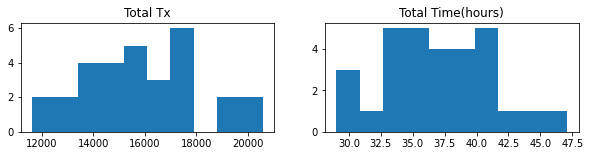

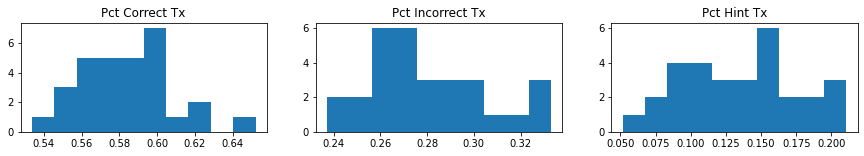

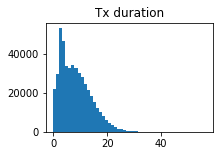

In [39]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(stu_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(stu_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(stu_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(stu_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(stu_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

In [40]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()

#prob_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id'])['duration'].count().reset_index()
#section_stats = step_stats.groupby(['stu_id', 'unit_id', 'section_id'])['sum'].agg(['count', np.mean, np.std])
#unit_stats = step_stats.groupby(['stu_id', 'unit_id'])['sum'].agg(['count', np.mean, np.std])


In [41]:
# Number of transactions with negative duration
# This is a sanity check
count = np.sum(tx['duration'] < 0)
logger.info("Number of transactions with negative duration: %i out of %i(%.2f%%)" % (count, tx.shape[0], count * 100 / tx.shape[0]))

INFO:main:Number of transactions with negative duration: 0 out of 477332(0.00%)


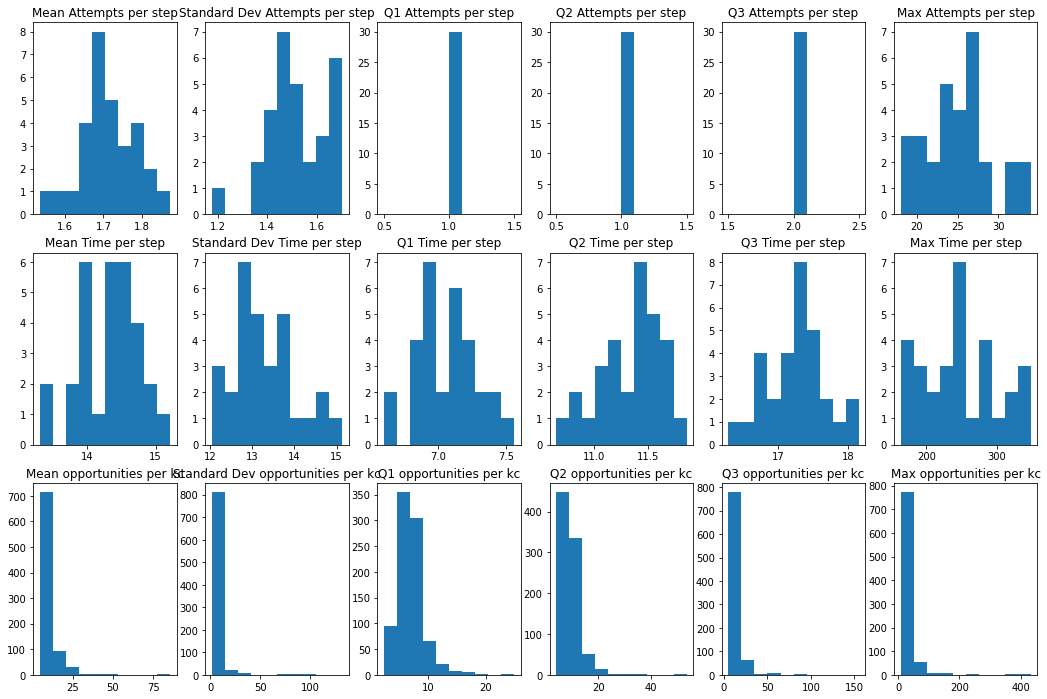

In [42]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


### Student to behavior EDA

In [43]:
# Merge behavioral stats with generated student measures
stus = pd.merge(sim_students, stu_stats, how='inner', left_on='_id', right_on=stu_stats.index)
logger.debug(stus.shape)
stus = pd.merge(stus, action_dist, how='inner', left_on='_id', right_on=action_dist.index)
for col in stus['values'][0].keys():
    stus['%s value' % col]  = stus.apply(lambda x: x['values'][col], axis=1)
logger.debug(stus.shape)
stus.head()

,_id,domain_id,type,skills,min_off_task,max_off_task,mean_guess_time,sd_guess_time,diligence,self_eff,...,Off Task,total,Pct Attempt,Pct Guess,Pct Hint Request,Pct Off Task,attempt value,guess value,hint request value,off task value
0,2311692b-3770-4407-a455-d49e35719486,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,{'f724a837-2aa8-4797-b801-67ceb2e43a82': False...,30,1200,3,1,2.060367,0.419716,...,5299,24741,0.572936,0.047371,0.165515,0.214179,9.285659,9.489020,5.229849,4.969073
1,54f8e8f9-b792-4473-89bb-e15991989572,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,{'f724a837-2aa8-4797-b801-67ceb2e43a82': False...,30,1200,3,1,2.304944,0.611095,...,1810,16856,0.727693,0.049359,0.115567,0.107380,10.099937,8.768698,2.790638,2.331106
2,81d87a8c-367c-432c-8d71-b0d7fe4bac0d,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,{'f724a837-2aa8-4797-b801-67ceb2e43a82': False...,30,1200,3,1,1.382105,0.322094,...,5483,23030,0.585758,0.056101,0.120061,0.238081,7.478762,5.366302,2.458330,2.820131
3,7d1a77c9-4c9e-439e-855f-a8da9ae10dd5,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,"{'f724a837-2aa8-4797-b801-67ceb2e43a82': True,...",30,1200,3,1,2.162972,0.313305,...,5171,21142,0.595592,0.039779,0.120045,0.244584,9.694667,7.513202,3.278880,5.699460
4,e1b14123-0c63-45e5-aef6-04dc8321dfec,fa479877-926f-4f3c-a0b1-8d70a4588c09,Self Efficacy Learner,{'f724a837-2aa8-4797-b801-67ceb2e43a82': False...,30,1200,3,1,2.278465,0.623705,...,3462,19698,0.699970,0.055234,0.069043,0.175754,10.737942,9.430263,1.499878,4.131506


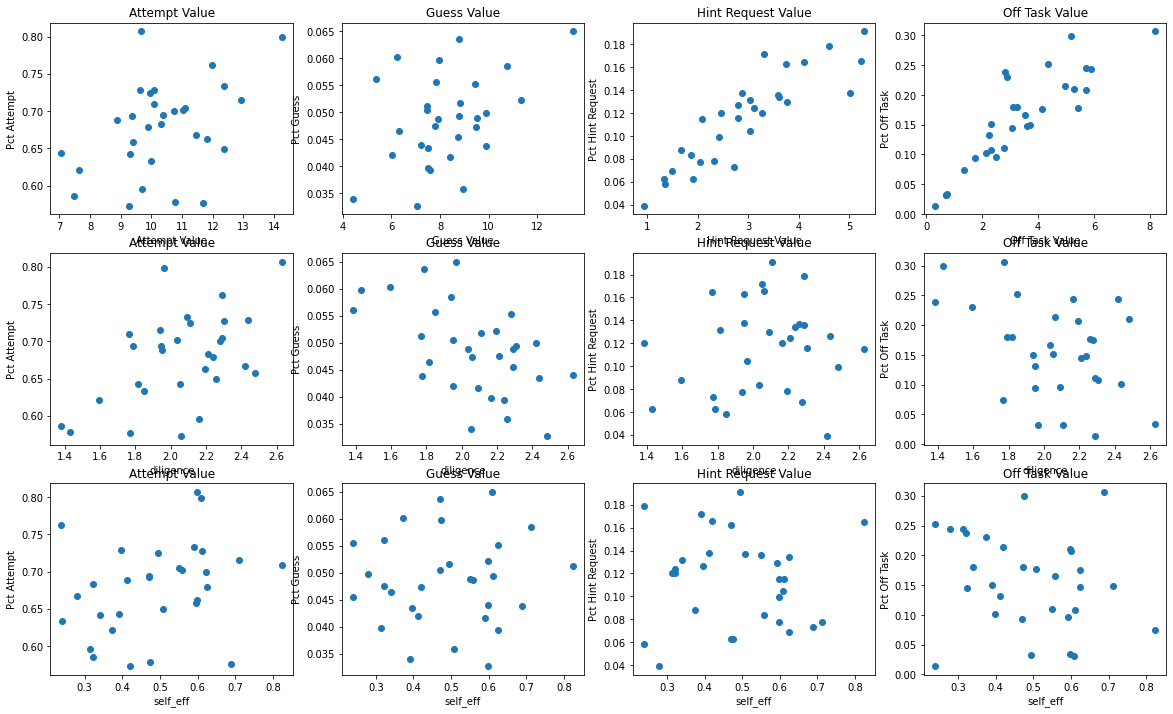

In [44]:
# Value vs action
num_bins = 10
num_rows = 3
num_cols = 4
row_height = 3
col_width = 5
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus['attempt value'], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel("Attempt Value")
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus['guess value'], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel("Guess Value")
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus['hint request value'], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel("Hint Request Value")
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus['off task value'], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel("Off Task Value")
plt.ylabel("Pct Off Task")

row = 1
xcol='diligence'
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus[xcol], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel(xcol)
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus[xcol], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel(xcol)
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus[xcol], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel(xcol)
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus[xcol], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel(xcol)
plt.ylabel("Pct Off Task")

row = 2
xcol='self_eff'
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.scatter(stus[xcol], stus['Pct Attempt'])
plt.title("Attempt Value")
plt.xlabel(xcol)
plt.ylabel("Pct Attempt")

plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.scatter(stus[xcol], stus['Pct Guess'])
plt.title("Guess Value")
plt.xlabel(xcol)
plt.ylabel("Pct Guess")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.scatter(stus[xcol], stus['Pct Hint Request'])
plt.title("Hint Request Value")
plt.xlabel(xcol)
plt.ylabel("Pct Hint Request")

plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.scatter(stus[xcol], stus['Pct Off Task'])
plt.title("Off Task Value")
plt.xlabel(xcol)
plt.ylabel("Pct Off Task")


plt.show()


In [45]:
for col in stus.columns:
    print(col)

_id
domain_id
type
skills
min_off_task
max_off_task
mean_guess_time
sd_guess_time
diligence
self_eff
values
total_attempts
total_success
final skills
final total attempts
final total success
pre-sim total mastery
final-sim total mastery
total skills
pre-sim pct mastery
final-sim pct mastery
final-sim total unmastered
final self-eff
pct success
Total Tx
Total Time
Total Time(hours)
Correct
Hint
Incorrect
Pct Correct
Pct Hint
Pct Incorrect
Attempt
Guess
Hint Request
Off Task
total
Pct Attempt
Pct Guess
Pct Hint Request
Pct Off Task
attempt value
guess value
hint request value
off task value


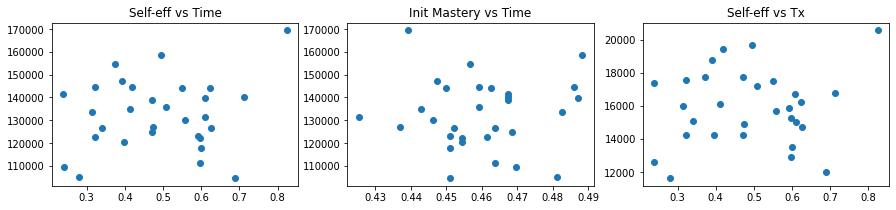

In [46]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.scatter(stus['self_eff'], stus['Total Time'])
plt.title("Self-eff vs Time")

plt.subplot(1,3,2)
plt.scatter(stus['pre-sim pct mastery'], stus['Total Time'])
plt.title("Init Mastery vs Time")


plt.subplot(1,3,3)
plt.scatter(stus['self_eff'], stus['Total Tx'])
plt.title("Self-eff vs Tx")

plt.show()
